## run a field-level IMNN on simulations with noise

In [1]:
import os

# change JAX GPU memory preallocation fraction
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from jax import config
config.update("jax_enable_x64", False)

%load_ext autoreload
%autoreload 2

import jax

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla V100-PCIE-32GB


In [2]:
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla V100-PCIE-32GB


In [3]:
cd ~/repositories/wl-sbi/imnn_scripts/

/home/makinen/repositories/wl-sbi/imnn_scripts


/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/makinen/venvs/lemur/lib64/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import math
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import optax
import matplotlib.pyplot as plt
from functools import partial
import flax.linen as nn

import jax.random as jr

import cloudpickle as pickle


np = jnp

from imnns import *
from imnn_update import *

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### pull in simulations and compute MOPED for Cls WITH NOISE

In [5]:
z_means_analysis = jnp.array([0.5, 0.75, 1.0, 1.25]) #jnp.array([0.5, 1.0, 1.5, 2.0])

def indices_vector(num_tomo):
   indices = []
   cc = 0
   for catA in range(0,num_tomo,1):
      for catB in range(catA,num_tomo,1):
        indices.append([catA, catB])
        cc += 1
   return indices

L = 250 #250
N = 192
cl_cut = -1 #14 #13 #6 # 13
skip = 12 #2

OUTBINS = 6
num_bins = OUTBINS
num_tomo = 4
Lgrid = (L, L, 4000)
Nmesh = (N, N, 512)
num_bins = jnp.ones(Nmesh[0]//2)[:cl_cut:skip].shape[0]
chi_grid = (jnp.arange(Nmesh[2]) + 0.5) * Lgrid[2] / Nmesh[2]
chi_source = chi_grid[-1]
indices = jnp.array(indices_vector(num_tomo))
cl_shape = indices.shape[0] * cl_cut

# NO NOISE FOR NOW
NOISEAMP = 0.25 #1.0 #0.25


do_noise = True

def compute_variance_catalog(zmean=z_means_analysis):

    N0 = Nmesh[0]
    N1 = Nmesh[1]
    N2 = Nmesh[2]
    L0 = Lgrid[0]
    L1 = Lgrid[1]
    L2 = Lgrid[2]
    
    Ncat = 4

    cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8) # no sigma8-dependence 
    rms = 0.3 / 2. # from review (corrected w Hall comment)
    a = 1. / (1. + zmean)
    dist = jc.background.radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256)
    angle = 2. * jnp.arctan((L0/N0/2) / dist)
    arcmin_angle = angle * 180. / np.pi * 60.
    arcmin2_pix = arcmin_angle**2
    sources = 30. / Ncat * arcmin2_pix # from Euclid
    return rms**2 / sources

noisevars = compute_variance_catalog()

noisevars

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Array([0.00025324, 0.00049203, 0.00075783, 0.00103168], dtype=float32)

In [6]:
#@jax.jit
def rotate_sim(k, sim):
    k = k % 4

    condition1 = (k > 0)
    condition2 = (k > 1)
    condition3 = (k > 2)
    condition4 = (k == 3)

    # if k == 0:
    def kzero(k):
        return sim
    # if k == 1:
    def kone(k):
        return jnp.rot90(sim, k=1, axes=(1,2))
    # if k == 2:
    def ktwo(k):
        return jnp.rot90(sim, k=2, axes=(1,2))
    def kthree(k):
        return jnp.rot90(sim, k=3, axes=(1,2))

    # if >2, use kthree, else use ktwo
    def biggerthantwo(k):
        return jax.lax.cond(condition3, true_fun=kthree, false_fun=ktwo, operand=k)

    # if > 1, return biggerthan2, else use kone
    def biggerthanone(k):
        return jax.lax.cond(condition2, true_fun=biggerthantwo, false_fun=kone, operand=k)

    # if >0 , return biggerthan1, else use kzero
    sim = jax.lax.cond(condition1, true_fun=biggerthanone, false_fun=kzero, operand=k)

    return sim

#@partial(jax.jit, static_argnums=(3,4))
def noise_simulator(key, sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim += (jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

In [7]:
from typing import Tuple

@jax.jit
def compute_auto_cross_angular_power_spectrum(
    field1: jnp.ndarray,
    field2: jnp.ndarray,
    distance: float,
    size: float,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Compute the auto or cross angular power spectrum of 2D arrays of data.

    Parameters:
        - field1 (jnp.ndarray): first 2D data field with shape (N, N).
        - field2 (jnp.ndarray): second 2D data field with shape (N, N). If the same field
            is provided, the auto- angular power spectrum is computed.
        - distance (float): Comoving distance to the plane.
        - size (float): Size of the patch in Mpc/h.

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray]: A tuple containing the filtered angular modes (ell) and
        the angular power spectrum values (Cl).

    """
    # Mesh properties
    Nx, Ny = field1.shape
    Npix = Nx * Ny

    # Fourier transform of the field
    field1_ft = jnp.fft.fftn(field1)
    field2_ft = jnp.fft.fftn(field2)


    # Angular size of the patch
    theta = size / distance

    # Fundamental angular mode
    ell_fundamental = 2.0 * jnp.pi / theta

    # Unbinned power spectrum. Mix the two fields.
    power_2D = field1_ft
    power_2D = power_2D.at[...].mul(jnp.conj(field2_ft))
    power_2D = power_2D.at[...].set(jnp.abs(power_2D).astype(jnp.float32) / Npix**2.)
    power_2D = power_2D.astype(jnp.float32)
    #power_2D = jnp.abs(field1_ft * jnp.conj(field2_ft)) / Npix**2.

    # Fourier modes of the box
    kx = jnp.fft.fftfreq(Nx, d=1.0) * Nx
    ky = jnp.fft.fftfreq(Ny, d=1.0) * Ny
    kx = kx[:, None]
    ky = ky[None, :]
    k_modes = jnp.sqrt(kx**2 + ky**2)

    # Angular modes
    ell_vals = (k_modes * ell_fundamental).flatten()

    # Binned power spectrum
    ell_bins = jnp.arange(0.5, Ny // 2 + 1, 1.0) * ell_fundamental
    ell = 0.5 * (ell_bins[1:] + ell_bins[:-1])
    power = power_2D.flatten()
    binned_power, _ = jnp.histogram(ell_vals, weights=power, bins=ell_bins)
    mode_counts, _ = jnp.histogram(ell_vals, bins=ell_bins)

    # Normalize the binned power spectrum
    Cl = (binned_power / mode_counts) * theta**2

    return ell, Cl

In [8]:
from functools import partial
from lemur import analysis, background, cosmology, limber, simulate, plot, utils, constants
from moped import *

import netket as nk
from jax import config
config.update("jax_enable_x64", False)

def get_spec(index, tomo_data, key):
    
    if do_noise:
        tomo_data = noise_simulator(key, tomo_data)

    ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])

    return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]
    
    # return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
    #                                             chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins(tomo_data, key, chunk_size=10):
    #gps = lambda i: get_spec(i, tomo_data, key)
    gps = partial(get_spec, tomo_data=tomo_data, key=key)
    return nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)



def get_spec_nonoise(index, tomo_data):
    
    ell,cl = compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
                                                chi_source, Lgrid[0])
    return jnp.histogram(ell[:cl_cut], weights=cl[:cl_cut], bins=OUTBINS)[0]


    # return analysis.compute_auto_cross_angular_power_spectrum(tomo_data[index[0]], tomo_data[index[1]],
    #                                             chi_source, Lgrid[0])[1][:cl_cut:skip]

def cls_allbins_nonoise(tomo_data, chunk_size=2):
    #gps = lambda i: get_spec_nonoise(i, tomo_data)
    gps = partial(get_spec_nonoise, tomo_data=tomo_data)
    return nk.jax.vmap_chunked(gps, chunk_size=chunk_size)(indices)


In [9]:
num_bins = OUTBINS

In [10]:
num_bins

6

In [11]:
from tqdm import tqdm as tq

### ------------- IMNN PARAMETERS -------------
#θ_fid = jnp.array([0.5, 1.162]) #jnp.array([0.5, 0.67])
θ_fid = jnp.array([0.3, 0.8])
δθ = 2*jnp.array([0.0115, 0.01]) # BIG DERV STEP

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))


n_summaries = 2

n_s = 1500
n_d = 750 // 2 #125

n_params = 2
n_summaries = n_params
print(θ_der)

L = Lgrid[0]
lpt_order = 2
outdir = "/data101/makinen/lemur_sims/pm_sims/"

# loop function to load all N256 simulations

fid = jnp.concatenate(jnp.array(
                    [jnp.load(outdir + "N192/fid/sim_%d.npy"%(i))[jnp.newaxis, ...] for i in range(n_s*2)]
                    ), axis=0)
derv = jnp.concatenate(jnp.array(
                    [jnp.load(outdir + "N192/derv/sim_%d.npy"%(i))[jnp.newaxis, ...] for i in range(n_d*2*2*2)]
                    ), axis=0).reshape(n_d*2, 2, 2, 4, N, N)


[[0.2885 0.8   ]
 [0.3    0.79  ]
 [0.3115 0.8   ]
 [0.3    0.81  ]]


In [12]:
fid.shape, derv.shape

((3000, 4, 192, 192), (750, 2, 2, 4, 192, 192))

In [13]:
#import jax
#jax.config.update("jax_disable_jit", True)

In [14]:
key = jr.key(88)
key,rng = jr.split(key)

fid_keys = jr.split(key, num=2*n_s)
derv_keys = jr.split(rng, num=2*n_d)
derv_keys = jnp.repeat(derv_keys, θ_der.shape[0], axis=0) # flattened repeated keys


# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
fid_cls = []
batch = 20
for i in tq(range(fid.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins)(fid[i*batch:(i+1)*batch], fid_keys[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    fid_cls.append(f_)

fid_cls = jnp.concatenate(fid_cls)

derv_cls = []
for i in tq(range(n_d*2*2*n_params // batch)):
    d_  = jax.vmap(cls_allbins)(derv.reshape(-1, num_tomo, Nmesh[0], Nmesh[1])[i*batch:(i+1)*batch], 
                               derv_keys[i*batch:(i+1)*batch])
    derv_cls.append(d_)

derv_cls = jnp.concatenate(derv_cls).reshape(n_d*2, 2, n_params, len(indices)*(num_bins))
# ----- -----

cl_shape = derv_cls.shape[-1]
# now initialise MOPED object

  0%|          | 0/150 [00:00<?, ?it/s]/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
100%|██████████| 150/150 [00:12<00:00, 12.26it/s]


In [16]:
derv_cls.shape

(750, 2, 2, 60)

In [17]:
ell,clsfoo = compute_auto_cross_angular_power_spectrum(fid[59, 0], fid[59, 0], chi_source, Lgrid[0])
np.argmin((ell - 2000)**2)

Array(19, dtype=int32)

In [16]:
ell

Array([  100.43279,   200.86559,   301.29837,   401.73117,   502.16397,
         602.5968 ,   703.02954,   803.46234,   903.89514,  1004.3279 ,
        1104.7607 ,  1205.1936 ,  1305.6262 ,  1406.0591 ,  1506.492  ,
        1606.9247 ,  1707.3574 ,  1807.7903 ,  1908.2231 ,  2008.6559 ,
        2109.0886 ,  2209.5215 ,  2309.954  ,  2410.3872 ,  2510.8198 ,
        2611.2524 ,  2711.6855 ,  2812.1182 ,  2912.5508 ,  3012.984  ,
        3113.4165 ,  3213.8494 ,  3314.2822 ,  3414.7148 ,  3515.148  ,
        3615.5806 ,  3716.0132 ,  3816.4463 ,  3916.879  ,  4017.3115 ,
        4117.7446 ,  4218.1772 ,  4318.6104 ,  4419.043  ,  4519.4756 ,
        4619.908  ,  4720.3413 ,  4820.774  ,  4921.207  ,  5021.6396 ,
        5122.0723 ,  5222.5054 ,  5322.938  ,  5423.371  ,  5523.8037 ,
        5624.2363 ,  5724.669  ,  5825.102  ,  5925.5347 ,  6025.968  ,
        6126.4004 ,  6226.833  ,  6327.2656 ,  6427.6987 ,  6528.132  ,
        6628.5645 ,  6728.997  ,  6829.4297 ,  6929.863  ,  7030

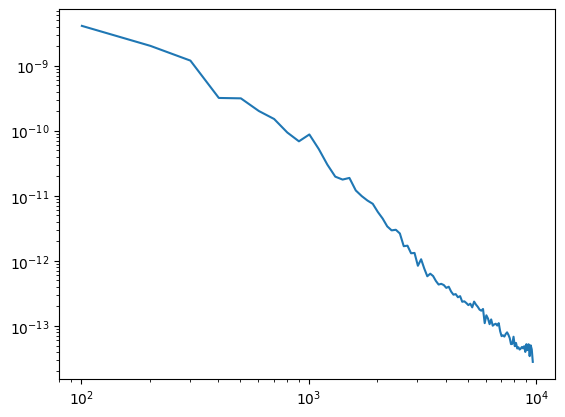

In [18]:
plt.loglog(ell, clsfoo)

In [19]:
#jnp.histogram(ell_vals, weights=power, bins=ell_bins)

clsbinnedfoo,binsfoo = jnp.histogram(ell, weights=clsfoo, bins=8)

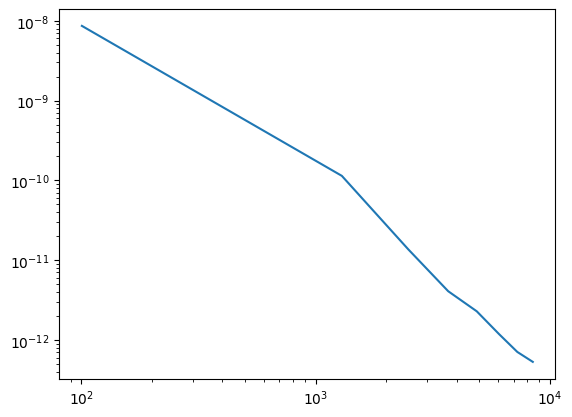

In [20]:
plt.loglog(binsfoo[:-1], clsbinnedfoo)

In [14]:
jax.config.update("jax_debug_nans", False)

In [15]:
mymoped = MOPED(n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=fid_cls[0].shape, 
                fiducial=fid_cls, 
                derivatives=derv_cls, 
                δθ=δθ, 
                θ_fid=θ_fid
               )

moped_summs = mymoped.compress(fid_cls)

# next we're going to do a second moped compression to get the derivatives into a smaller space.
# you can check to see that the fisher is the same for both !
mymoped2 = MOPED(
                n_param=2, n_d=n_d*2, n_s=n_s*2, 
                input_shape=(2,), 
                fiducial=mymoped.compress(fid_cls), 
                derivatives=mymoped.compress(derv_cls.reshape((-1,) + fid_cls[0].shape)).reshape(n_d*2, 2, 2, 2), 
                δθ=δθ, 
                θ_fid=θ_fid
)

print("moped 2 F:", mymoped2.F, "moped 1 F:", mymoped.F)
print("moped 2 F:", jnp.linalg.det(mymoped2.F), "moped 1 F:", jnp.linalg.det(mymoped.F))

moped_statistic = dict(
        n_t = 2,
        mean_derivatives = mymoped2.mu_dervs,
        covariance = mymoped.invF,
        Fisher = mymoped.F,
        fid_summaries=mymoped.compress(fid_cls),
)

moped 2 F: [[5431.567  2823.3547]
 [2823.3547 2259.2703]] moped 1 F: [[5431.557  2823.3447]
 [2823.2542 2259.1907]]
moped 2 F: 4300046.0 moped 1 F: 4299903.5


In [22]:
# split into train and val sets

val_fid = fid[n_s:]
val_derv = derv[n_d:]

fid = fid[:n_s]
derv = derv[:n_d]


# save the split datasets
outdir = "/data101/makinen/lemur_sims/pm_sims/N192/"
jnp.save(outdir + "val_fid", val_fid)
jnp.save(outdir + "fid", fid)
jnp.save(outdir + "val_derv", val_derv)
jnp.save(outdir + "derv", derv)

(fid.shape, derv.shape), (val_fid.shape, val_derv.shape)

(((1500, 4, 192, 192), (375, 2, 2, 4, 192, 192)),
 ((1500, 4, 192, 192), (375, 2, 2, 4, 192, 192)))

In [16]:
del fid, derv

# NPE code

In [17]:
from NPE import npe
from NPE.multipole_cnn import MultipoleConv
from NPE.multipole_cnn_factory import MultipoleCNNFactory

## network code

In [18]:
# load mdn thing
from typing import Sequence, Callable
import jax
from jax.scipy.special import logsumexp # Compute the log of the sum of exponentials of input elements
from jax.nn import softmax # pretty much the same as the interface as the one in scipy.special

import flax.linen as nn

np = jnp

import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)


class MLP(nn.Module):
  features: Sequence[int]
  act: nn.activation = nn.tanh

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = self.act(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


In [19]:
from typing import Any, Callable, Sequence, Optional, Union
from flax.core import freeze, unfreeze
import flax.linen as nn

import jax
import jax.numpy as jnp

Array = Any

@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.

  Computes the element-wise function:

  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}

  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x)) / 3.5



def next_power_of_two(number):
    # Returns next power of two following 'number'
    return math.ceil(math.log2(number))

def conv_outs(W, K=2, P=0, S=3):
    return math.ceil(((W - K + (2*P)) / S )+1)

#@jax.jit
def get_padding_pow2(arraylen):
    """
    helper function to pad uneven strided outputs
    """
    
    next_power = next_power_of_two(arraylen)
    deficit = int(math.pow(2, next_power) - arraylen) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)

def get_padding(arraylen, padto):
    """
    helper function to pad uneven strided outputs
    """
    
    #next_power = next_power_of_two(arraylen)
    deficit = int(padto - arraylen + 1) # how much extra to pad
    
    # but we want to pad both sides of a given axis, so return a tuple here
    
    left = deficit // 2
    right = left + (deficit % 2)
    
    return (left, right)


# TODO: try maxpool layer in one of the blocks ?


class InceptStride(nn.Module):
    """Inception block submodule"""
    filters: Sequence[int]
    pad_shape: int
    act: Callable = almost_leaky
    do_1x1: bool = True
    do_4x4: bool = True
    dim: int = 2
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, x):

        d = self.dim
            
        # 2x2 stride
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*self.dim, 
                     strides=(2,)*d if d == 2 else (2,2,1), 
                     padding="CIRCULAR", dtype=self.dtype)(x)
        z = self.act(x2)
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(z)
        x2 = self.act(x2 + z)

        # 2x2 stride with pool
        # x2p = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, 
        #               strides=(2,)*d if d == 2 else (2,2,1), 
        #               padding="CIRCULAR")(x)
        # x2p = self.act(x2p)
        # x2p = nn.max_pool(x2p, (4,4), strides=None, padding="SAME")
        

        # 3x3 stride
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                     strides=(3,)*d if d == 2 else (3,3,1), 
                     padding="CIRCULAR", dtype=self.dtype)(x)
        z = self.act(x3)
        x3 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(z)
        x3 = self.act(x3 + z)

        # 4x4 stride
        if self.do_4x4:
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, 
                         strides=(4,)*d if d == 2 else (4,4,1), 
                         padding="CIRCULAR")(x)
            z = self.act(x4)
            x4 = nn.Conv(features=self.filters[1], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(z)
            x4 = self.act(x4 + z)

        
        # now pad the 3x3 and concatenate it to the 2x2 stride
        x3shape = conv_outs(W=self.pad_shape)
        pads = get_padding(x3shape, x2.shape[0])
        
        x3 = jnp.pad(x3, 
                     pad_width=(pads, pads, (0,0),) if d == 2 else (pads, pads, (0,0), (0,0)), 
                     mode="wrap")
        x2 = jnp.concatenate([x2, x3], -1)

        # run another conv for the concated versions
        x2 = nn.Conv(features=self.filters[0], kernel_size=(2,)*d, strides=(1,)*d, 
                     padding="CIRCULAR", dtype=self.dtype)(x2)
        x2 = self.act(x2)
        

        # optional no stride embedding
        if self.do_1x1:
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(x)
            z = self.act(x1)
            x1 = nn.Conv(features=self.filters[2], kernel_size=(2,)*d, strides=(1,)*d, 
                         padding="CIRCULAR", dtype=self.dtype)(z)
            x1 = self.act(x1 + z)

            return x1, x2, x4

        elif self.do_4x4:
            return x2, x4

        else:
            return x2



In [20]:
next_power_of_two(3)

2

In [19]:
q = 192
for i in range(8):
    q /= 2
    print(q)

96.0
48.0
24.0
12.0
6.0
3.0
1.5
0.75


In [20]:
# TODO: should we make this layer a residual layer ?

class MPK_layer(nn.Module):
    multipole_layers: Sequence[MultipoleConv]
    act: Callable = almost_leaky

    @nn.compact
    def __call__(self, x):
        for i,l in enumerate(self.multipole_layers):
            z = l(x)
            x = self.act(z) if i == 0 else self.act(x + z)
        return x
        
# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)

class MDN_net_stacked(nn.Module):
    """An incept net architecture"""
    filters: Sequence[int]
    #mlp_features: Sequence[int]
    multipole_tomo1: MPK_layer
    #multipole_tomo2: MPK_layer
    #multipole_tomo3: MPK_layer
    #multipole_tomo4: MPK_layer
    # mpk_stack1: MPK_layer
    # mpk_stack2: MPK_layer
    # mpk_stack3: MPK_layer
    # mpk_stack4: MPK_layer
    # mpk_stack5: MPK_layer
    div_factor: float = 0.02
    n_outs: int = 1
    act: Callable = nn.swish
    dtype: Any = jnp.bfloat16
    
    @nn.compact
    def __call__(self, x):

        filters = self.filters

        # add in Cls information
        cls_summs = cls_allbins_nonoise(jax.lax.stop_gradient(x.astype(self.dtype))).reshape(-1, cl_shape)
        cls_summs = mymoped.compress(jax.lax.stop_gradient(cls_summs)).reshape(-1) # moped compress

        # pass to trained mdn layer
        #mdn_summs = (get_summaries_mdn(jax.lax.stop_gradient(x)))


        
        # try clipping the field
        # xlog = (log_transform(x) * scale_data).transpose((1, 2, 0))
        # xclip = (clip_transform(x) * scale_data).transpose((1, 2, 0))

        # xlog = cls_allbins_nonoise(jax.lax.stop_gradient(xlog)).reshape(-1)
        # xclip = cls_allbins_nonoise(jax.lax.stop_gradient(xclip)).reshape(-1)

        #x *= scale_data
        #x /= 0.02
        
        xlog = (log_transform(jax.lax.stop_gradient(x)) / 0.02).transpose((1,2,0))
        #xclip = (clip_transform(x) / 0.02).transpose((1,2,0))

       # # do field-level net
        #x0 = jnp.transpose(x, (1, 2, 0)) / 0.02

        x = xlog + 1.0 # jnp.concatenate([xlog, xclip, x0], -1)

        # def gethist(data):
        #   return jnp.histogram(data, bins=7, density=True)[0]

        # xd = jax.vmap(gethist)(x.T).reshape(-1)

        #x0 = x

        x = x.astype(self.dtype)
        x = self.multipole_tomo1(x)

        #print(x.shape)

        #x_1_128, x_0_64 = InceptStride(filters=[1,1,1], pad_shape=256, act=self.act, do_1x1=False, dtype=self.dtype)(x)
        
        x_1_64, x_1_32 = InceptStride(filters=[1,1,1], pad_shape=192, act=self.act, do_1x1=False, dtype=self.dtype)(x)
        #x_1_64 = jnp.concatenate([x_1_64, x_0_64], -1)

        #filters = [f*2 for f in filters]
        # continue along the tree (no stride-1 this time)
        x_2_32, x_2_16 = InceptStride(filters=filters, pad_shape=96, act=self.act, do_1x1=False, dtype=self.dtype)(x_1_64)
        # now concatenate the remaining 32x32 arrays
        x_2_32 = jnp.concatenate([x_1_32, x_2_32], -1)
        # now cut down to 16x16
        filters = [f*2 for f in filters]
        x_3_16, x_2_8 = InceptStride(filters=filters, pad_shape=48, act=self.act, do_1x1=False, dtype=self.dtype)(x_2_32)
        # concatenate the remaining 16x16 array
        x_3_16 = jnp.concatenate([x_2_16, x_3_16], -1)
        # now cut down to 8x8
        # --- current best
        filters = [f*2 for f in filters]
        x_3_8 = InceptStride(filters=filters, pad_shape=24, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x_3_16)
        # OUTPUT IS 12x12
        x = jnp.concatenate([x_2_8, x_3_8], -1)
        # --- current best

        # cutting down to 6x6
        # filters = [f*2 for f in filters]
        # x_3_8, x_3_4 = InceptStride(filters=filters, pad_shape=24, act=self.act, do_1x1=False, do_4x4=True, dtype=self.dtype)(x_3_16)
        # # OUTPUT IS 12x12
        # x = jnp.concatenate([x_2_8, x_3_8], -1)
        
        # filters = [f*2 for f in filters]
        # x = InceptStride(filters=filters, pad_shape=12, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x)
        # # OUTPUT IS 6x6
        # x = jnp.concatenate([x, x_3_4], -1)

        #filters = [f*2 for f in filters]
        #x_3_8 = InceptStride(filters=filters, pad_shape=12, act=self.act, do_1x1=False, do_4x4=False, dtype=self.dtype)(x)
        # concatenate the 8x8s
        #x = jnp.concatenate([x_2_8, x_3_8], -1)
        
        x = x.mean(axis=(0,1))
        x = x.reshape(-1)
        x = nn.Dense(self.n_outs, dtype=self.dtype)(x).reshape(1,-1)
        x = x.reshape(-1).astype(jnp.float32) # make sure output is float32

        return jnp.concatenate([cls_summs.reshape(-1), x])




In [21]:
#plt.plot(cls_allbins_nonoise(clipped).reshape(-1))

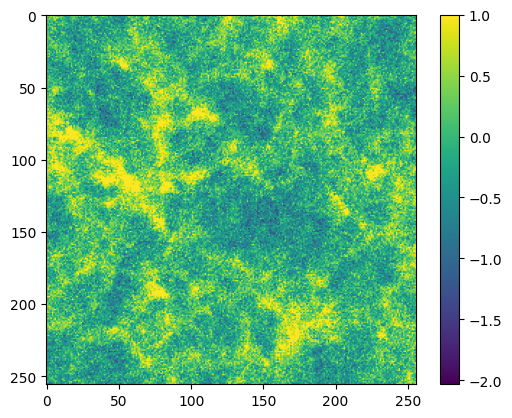

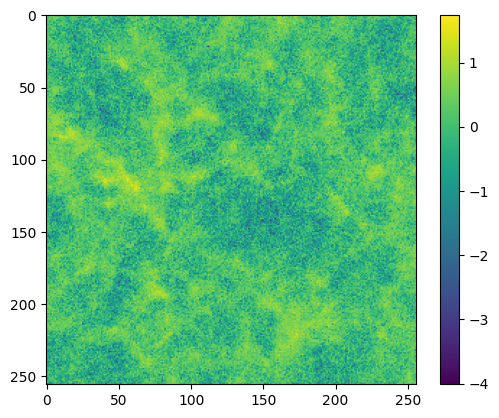

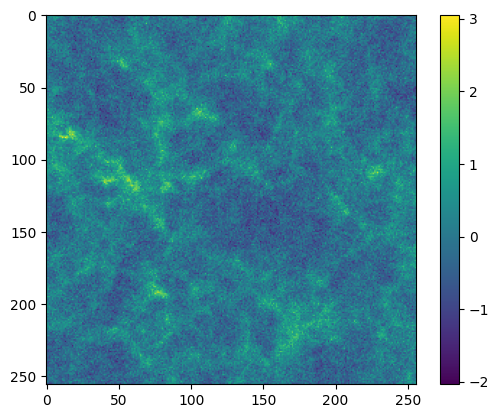

In [29]:
foo = noise_simulator(key, fid[0], rot=False)

# log transform
def log_transform(x):
    xo = jnp.abs(x.min(axis=0, keepdims=True)) + 0.01
    return xo * jnp.log(1.0 + (x / xo))

def clip_transform(x, clipval=0.02):
    return jnp.where(x > clipval, clipval, x)


clipped = clip_transform(foo) / 0.02
logged = log_transform(foo) / 0.02

plt.imshow(clipped[1, ...])
plt.colorbar()
plt.show()


plt.imshow(logged[1, ...]  + 0.1)
plt.colorbar()
plt.show()

plt.imshow(foo[1, ...] / 0.02)
plt.colorbar()
plt.show()

In [79]:
%xmode context

Exception reporting mode: Context


In [21]:
#model = nn.Conv(features=5, kernel_size=(2,2), strides=3, padding="CIRCULAR")
#model = InceptNet(filters=[5,5,20])

# maybe do each tomo bin separately, concatenate, and then continue with downconvs 

dtype = jnp.bfloat16

mpk_layer = MultipoleCNNFactory(
             kernel_shape=(13,13),
            #kernel_shape=(7,7),
             polynomial_degrees=[0,1,2],
             output_filters=None,
             dtype=dtype)


strides1 = [1,1]
strides2 = [1,1]
strides3 = [1,1]
strides4 = [1,1]
strides5 = [1,1]

input_filters1 = [4,1,1]

input_filters_rest = [4, 6]

act = almost_leaky

model = MDN_net_stacked(filters=[3,3,3], 
                        # rest of network
                        multipole_tomo1 = MPK_layer(multipole_layers=[mpk_layer.build_cnn_model(num_input_filters=f,
                                                                   strides=strides1[i],
                                                                   pad_size=None) for i,f in enumerate(input_filters_rest)],
                                                                   act=act),
                        act=act, 
                        n_outs=1,
                        dtype=dtype
)

# foo = jnp.load(outdir + "fid.npy")[0]
# w = model.init(jr.PRNGKey(44), jnp.zeros((4, N, N)))
# x = model.apply(w, noise_simulator(key, foo))

# x

In [23]:
x

Array([0.29441872, 0.78971314, 0.07958984], dtype=float32)

In [35]:
(L / N) * 15, (250 / 128) * 7

(19.53125, 13.671875)

In [24]:
import netket as nk
from jax import config
config.update("jax_enable_x64", False)

In [22]:
from imnns import *
#from imnn_update import *
from imnn_update import _updateIMNN, _check_input
import netket as nk
from jax import config
config.update("jax_enable_x64", False)



# NOISE NUMERICAL GRADIENT IMNN
class newNoiseNumericalGradientIMNN(_updateIMNN):
    """Information maximising neural network fit with simulations on-the-fly
    """
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid, δθ,
                 model, optimiser, key_or_state,
                 noise_simulator, 
                 fiducial, derivative,
                 chunk_size=100,
                 validation_fiducial=None, validation_derivative=None, 
                 existing_statistic=None,
                 dummy_graph_input=None,
                 no_invC=False, do_reg=True,
                 evidence=False):
        """Constructor method

        Initialises all IMNN attributes, constructs neural network and its
        initial parameter values and creates history dictionary. Also checks
        validity of simulator and sets the ``simulate`` attribute to ``True``.

        Parameters
        ----------
        n_s : int
            Number of simulations used to calculate summary covariance
        n_d : int
            Number of simulations used to calculate mean of summary derivative
        n_params : int
            Number of model parameters
        n_summaries : int
            Number of summaries, i.e. outputs of the network
        input_shape : tuple
            The shape of a single input to the network
        θ_fid : float(n_params,)
            The value of the fiducial parameter values used to generate inputs
        model : tuple, len=2
            Tuple containing functions to initialise neural network
            ``fn(rng: int(2), input_shape: tuple) -> tuple, list`` and the
            neural network as a function of network parameters and inputs
            ``fn(w: list, d: float(None, input_shape)) -> float(None, n_summari
            es)``.
            (Essentibly stax-like, see `jax.experimental.stax <https://jax.read
            thedocs.io/en/stable/jax.experimental.stax.html>`_))
        optimiser : tuple, len=3
            Tuple containing functions to generate the optimiser state
            ``fn(x0: list) -> :obj:state``, to update the state from a list of
            gradients ``fn(i: int, g: list, state: :obj:state) -> :obj:state``
            and to extract network parameters from the state
            ``fn(state: :obj:state) -> list``.
            (See `jax.experimental.optimizers <https://jax.readthedocs.io/en/st
            able/jax.experimental.optimizers.html>`_)
        key_or_state : int(2) or :obj:state
            Either a stateless random number generator or the state object of
            an preinitialised optimiser
        simulator : fn
            A function that generates a single simulation from a random number
            generator and a tuple (or array) of parameter values at which to
            generate the simulations. For the purposes of use in LFI/ABC
            afterwards it is also useful for the simulator to be able to
            broadcast to a batch of simulations on the zeroth axis
            ``fn(int(2,), float([None], n_params)) ->
            float([None], input_shape)``
        dummy_graph_input : jraph.GraphsTuple or 'jax.numpy.DeviceArray'
            Either a (padded) graph input or device array. If supplied ignores 
            `input_shape` parameter
        """
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            optimiser=optimiser,
            key_or_state=key_or_state,
            existing_statistic=existing_statistic,
            dummy_graph_input=dummy_graph_input,
            no_invC=no_invC,
            do_reg=do_reg,
            evidence=evidence)

        self.chunk_size = chunk_size
        self.existing_statistic = existing_statistic
        self.simulator = noise_simulator
        #self.simulate = True
        self.dummy_graph_input = dummy_graph_input
        self.θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), 
                                        np.diag(δθ) / 2.)).reshape((-1, 2))
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        
        # NUMERICAL GRADIENT SETUP
        self._set_data(δθ, fiducial, derivative, validation_fiducial,
                       validation_derivative)


    def _set_data(self, δθ, fiducial, derivative, validation_fiducial,
                  validation_derivative):
        """Checks and sets data attributes with the correct shape
        """
        self.δθ = np.expand_dims(
            _check_input(δθ, (self.n_params,), "δθ"), (0, 1))
        # if self.dummy_graph_input is None:
        #   self.fiducial = _check_input(
        #       fiducial, (self.n_s,) + self.input_shape, "fiducial")
        #   self.derivative = _check_input(
        #       derivative, (self.n_d, 2, self.n_params) + self.input_shape,
        #       "derivative")
        #   if ((validation_fiducial is not None)
        #           and (validation_derivative is not None)):
        #       self.validation_fiducial = _check_input(
        #           validation_fiducial, (self.n_s,) + self.input_shape,
        #           "validation_fiducial")
        #       self.validation_derivative = _check_input(
        #           validation_derivative,
        #           (self.n_d, 2, self.n_params) + self.input_shape,
        #           "validation_derivative")
        #       self.validate = True
        # else:
        self.fiducial = fiducial
        self.derivative = derivative

        if ((validation_fiducial is not None)
              and (validation_derivative is not None)):
          self.validation_fiducial = validation_fiducial
          self.validation_derivative =  validation_derivative
          self.validate = True

    # function to assign keys to dictionary to do vmap_chunked in batches with one argument
    def _assign_keys(self, key, data):
        return dict(key=key,
                    data=data)


    def _collect_input(self, key, validate=False):
        """ Returns validation or fitting sets
        """
        if validate:
            fiducial = self.validation_fiducial
            derivative = self.validation_derivative
        else:
            fiducial = self.fiducial
            derivative = self.derivative


        # use fnames to load in dataset
        #fiducial = jnp.load(fiducial)[:self.n_s]
        #derivative = jnp.load(derivative)[:self.n_d]
            
        # add noise to data and make cuts
        keys = np.array(jax.random.split(key, num=self.n_s))
        # FIDUCIAL IS NOW A DICTIONARY
        fiducial = jax.vmap(self._assign_keys)(keys, fiducial) # this is inexpensive
        fiducial = nk.jax.vmap_chunked(self.simulator, chunk_size=self.chunk_size)(fiducial) # output is array

        
        _shape = derivative.shape
        # DERIVATIVE IS NOW A DICTIONARY
        derivative = jax.vmap(self._assign_keys)(np.repeat(keys[:self.n_d], 2*self.n_params, axis=0), 
                                                 derivative.reshape((self.n_d * 2 * self.n_params,) + self.input_shape))
        
        derivative = nk.jax.vmap_chunked(self.simulator, chunk_size=self.chunk_size)(derivative).reshape(_shape) # output is array
        # returns arrays, not dictionaries          
        return fiducial, derivative

    def _get_fitting_keys(self, rng):
        """Generates random numbers for simulation

        Parameters
        ----------
        rng : int(2,)
            A random number generator

        Returns
        -------
        int(2,), int(2,), int(2,)
            A new random number generator and random number generators for
            fitting (and validation)
        """
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key=None, validate=False):
        """Gets all network outputs and derivatives wrt model parameters
        """
        d, d_mp = self._collect_input(key, validate=validate)
        
        
        if self.dummy_graph_input is None:
          _model = lambda d: self.model(w, d)
          # try the netket batched vmap
          # nk.jax.vmap_chunked(f, in_axes=0, *, chunk_size, axis_0_is_sharded=False)
          x = nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(d)
          x_mp = np.reshape(
              nk.jax.vmap_chunked(_model, chunk_size=self.chunk_size)(
                    d_mp.reshape(
                      (self.n_d * 2 * self.n_params,) + self.input_shape)),
              (self.n_d, 2, self.n_params, self.n_summaries))

        else:
          # if operating on graph data, we need to vmap the implicit
          # batch dimension
          _model = lambda d: self.model(w, d)
          x = jax.vmap(_model)(d)
          x_mp = np.reshape(
              jax.vmap(_model)(d_mp),
              (self.n_d, 2, self.n_params, self.n_summaries))

        return x, x_mp

    def _construct_derivatives(self, x_mp):
        """Builds derivatives of the network outputs wrt model parameters
        """
        return np.swapaxes(x_mp[:, 1] - x_mp[:, 0], 1, 2) / self.δθ


In [73]:
val_fid.shape, val_derv.shape

((1500, 4, 256, 256), (375, 2, 2, 4, 256, 256))

In [76]:
foobar = jnp.ones((4,256,256))
jnp.save("test", foobar)

@jax.jit
def loadtest():
    foo = jnp.load("test.npy")
    foo += jr.normal(key, shape=foo.shape)
    return foo

In [78]:
%time jax.block_until_ready(loadtest())

CPU times: user 8.8 ms, sys: 2.98 ms, total: 11.8 ms
Wall time: 7.64 ms


Array([[[ 1.9464235 ,  1.3078014 ,  0.8582345 , ...,  1.1394225 ,
          1.271808  ,  0.90085626],
        [ 1.1118612 ,  1.4909351 ,  1.4149774 , ...,  0.5763792 ,
          0.7162766 ,  1.7202445 ],
        [ 0.44479322,  0.89276296, -0.22429812, ...,  0.42211485,
          1.092753  ,  1.2817788 ],
        ...,
        [ 0.15478587,  1.2549434 , -1.8971148 , ...,  0.79391754,
         -0.20457816,  2.2736049 ],
        [ 1.3423386 ,  1.7648371 ,  1.6099966 , ...,  2.0609    ,
          1.3306615 ,  0.21645236],
        [-0.70797575,  0.05729806,  0.17158586, ..., -0.20652556,
          2.4841833 ,  2.0104823 ]],

       [[ 0.75325984,  0.36983025,  0.38456774, ...,  0.6193094 ,
          2.5303035 , -0.9031627 ],
        [-0.16889   ,  1.8463176 ,  0.6345469 , ...,  1.758491  ,
          0.3673994 ,  0.7110994 ],
        [ 0.38347143,  2.2692308 ,  1.7453117 , ...,  0.90814376,
          1.4963257 ,  0.53896105],
        ...,
        [ 0.71945196,  0.81939864,  2.7745624 , ...,  

In [34]:
import jax
jax.config.update("jax_disable_jit", False)

In [27]:
δθ, θ_fid

(Array([0.023, 0.02 ], dtype=float64), Array([0.3, 0.8], dtype=float64))

In [23]:
import gc



def noise_simulator_dict(sim, noisescale=NOISEAMP, rot=True, noisevars=noisevars):
    key = sim["key"] # assigned in IMNN scheme
    sim = sim["data"]
    key1,key2 = jr.split(key)
    # do rotations of simulations
    k = jr.choice(key1, jnp.array([0,1,2,3]), shape=())
    if rot:
     sim = rotate_sim(k, sim)
    else:
     sim = sim

    # now add noise
    # this generates white noise across all pixels and then increases the amplitude
    sim = sim.at[...].add(jr.normal(key2, shape=(4,N,N)) * noisescale * jnp.sqrt(noisevars).reshape(4,1,1))
    return sim

#model = InceptNet(filters=[5,5,5], multipole_cnn=pole_layer, act=nn.swish, n_outs=1) # nn.swish

lr_schedule = optax.exponential_decay(init_value=1e-4, 
                        transition_begin=80,
                        transition_steps=150, 
                        decay_rate=0.5, 
                        end_value=1e-5
                       )


#optimiser = optax.adam(learning_rate=5e-5) # 5e-5

#optimiser = optax.sgd(learning_rate=1e-3, momentum=0.9)

# Clip gradients at max value, and evt. apply weight decay
transf = [optax.clip(1.0)]
transf.append(optax.add_decayed_weights(1e-4))
optimiser = optax.chain(
    *transf,
    #optax.sgd(learning_rate=5e-4, momentum=0.9)
    optax.adam(learning_rate=5e-4)
)

model_key = jr.PRNGKey(44)
key = jr.PRNGKey(55)
rng, key = jr.split(key)
input_shape = (4, N, N)


# moped_statistic_long = dict(
#         n_t = derv_cls.shape[-1],
#         mean_derivatives = mymoped.mu_dervs,
#         covariance = mymoped.C,
#         Fisher = mymoped.F,
#         fid_summaries=fid_cls,
# )

outdir = "/data101/makinen/lemur_sims/pm_sims/N192/"


# brute force method now
n_s_eff = 1000
n_d_eff = 250 
gc.collect()
IMNN =  newNoiseNumericalGradientIMNN(
    n_s=n_s_eff, n_d=n_d_eff, n_params=n_params, n_summaries=3 ,
    input_shape=input_shape, θ_fid=θ_fid, δθ=δθ, model=model,
    optimiser=optimiser, key_or_state=jnp.array(model_key),
    noise_simulator=partial(noise_simulator_dict, 
                            noisescale=NOISEAMP, rot=True),
    chunk_size=2,
    fiducial=jnp.load(outdir + "val_fid.npy")[-n_s_eff:], # outdir + "val_fid.npy", #
    derivative=jnp.load(outdir + "val_derv.npy")[-n_d_eff:], # outdir + "val_derv.npy",  
    validation_fiducial=jnp.load(outdir + "fid.npy")[-n_s_eff:], # outdir + "fid.npy", 
    validation_derivative=jnp.load(outdir + "derv.npy")[-n_d_eff:], # outdir + "val_derv.npy", 
    #existing_statistic=None,
    existing_statistic=moped_statistic,
    no_invC=True, # True
    evidence=True
)
gc.collect()
#wbest = load_obj(outdir + "imnn_weights_inceptstride_npe_res_S8_L_%d_smallstep.pkl"%(L))
wbest = load_obj(outdir + "imnn_w_N_%d_allell.pkl"%(N))
IMNN.set_F_statistics(wbest, key)

/home/makinen/venvs/lemur/lib64/python3.11/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


In [65]:
250 * 2 * 2

1000

In [64]:
IMNN.derivative.shape

(250, 2, 2, 4, 192, 192)

In [25]:
IMNN.set_F_statistics(IMNN.w, key)

In [24]:
IMNN.F, mymoped.F # detF 4680780

(Array([[11245.729 ,  3384.1396],
        [ 3384.1392,  2298.0388]], dtype=float32),
 Array([[5431.557 , 2823.3447],
        [2823.2542, 2259.1907]], dtype=float32))

In [88]:
import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [70]:
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.25'

In [74]:
%xmode verbose

Exception reporting mode: Verbose


In [25]:
gc.collect()
key,rng = jax.random.split(key) # retrain # patience=75, min_its=300 
IMNN.fit(10.0, 0.01, γ=1.0, rng=jnp.array(rng), print_rate=2, patience=150, max_iterations=7000, min_iterations=300) # patience=200

  0%|          | 0/7000 [00:00<?, ?it/s]

In [28]:
1572864000 / 1e9

1.572864

In [26]:
IMNN.F, mymoped.F # detF 2830889.0

(Array([[11485.953 ,  3328.8662],
        [ 3328.866 ,  2301.354 ]], dtype=float32),
 Array([[5431.557 , 2823.3447],
        [2823.2542, 2259.1907]], dtype=float32))

In [38]:
IMNN.F, mymoped.F # detF 2830889.0

(Array([[11103.379 ,  3362.3628],
        [ 3362.3628,  2309.803 ]], dtype=float32),
 Array([[5431.569 , 2823.352 ],
        [2823.2788, 2259.2153]], dtype=float32))

In [243]:
# run for about 4000 iterations; I think the dense layer at the end makes train and val diverge faster
# trying now with almost_leaky act

In [52]:
1572864000 / 1e9

1.572864

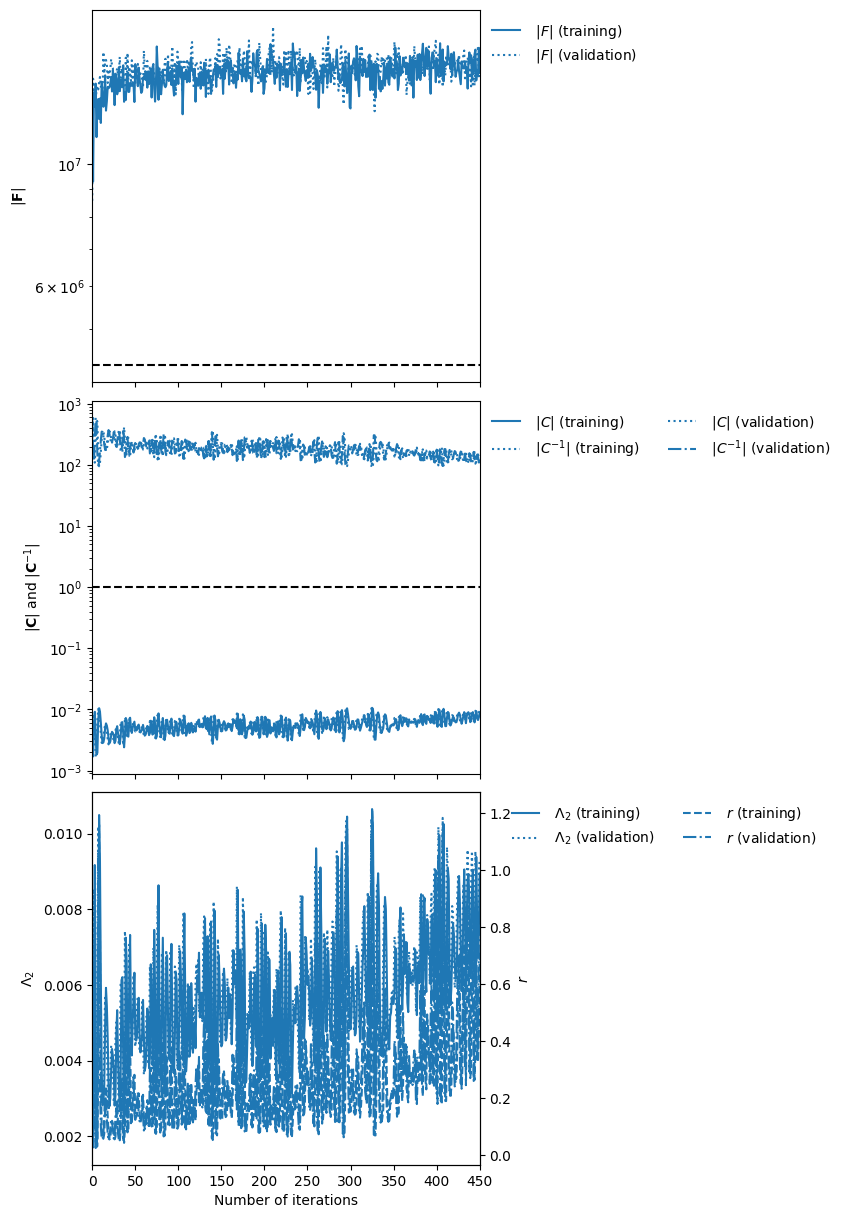

In [27]:
ax = IMNN.plot(expected_detF=jnp.linalg.det(mymoped.F))
ax[0].set_yscale("log")

In [37]:
outdir, N

('/data101/makinen/lemur_sims/pm_sims/N192/', 192)

In [28]:
save_obj(IMNN.w, outdir + "imnn_w_N_%d_allell_continued"%(N))

In [32]:
# end of training
IMNN.F, mymoped.F

(Array([[11320.84  ,  3384.1826],
        [ 3384.1829,  2217.898 ]], dtype=float32),
 Array([[5431.569 , 2823.352 ],
        [2823.2788, 2259.2153]], dtype=float32))

In [31]:
jnp.linalg.det(IMNN.F)

Array(12067087., dtype=float32)

In [32]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(2.8061697, dtype=float32)

In [29]:
jnp.linalg.det(IMNN.F) / jnp.linalg.det(mymoped.F)

Array(3.5702884, dtype=float32)

In [30]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

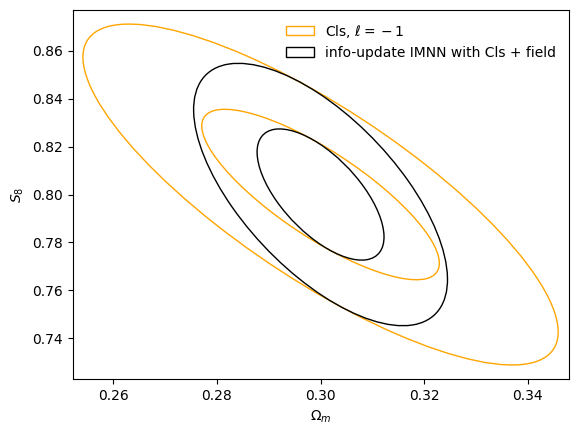

In [31]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=-1$",  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

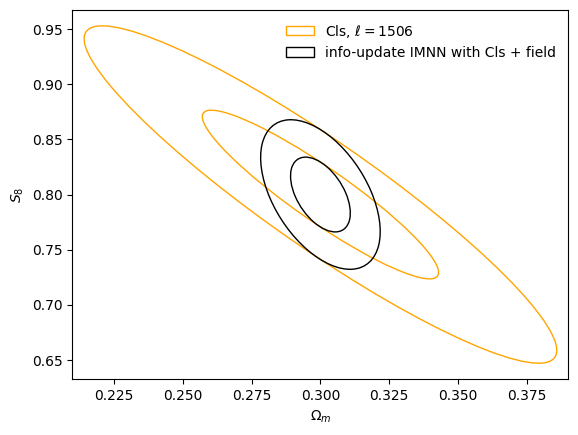

In [265]:
mean = θ_fid # Example mean vector

fishers = [mymoped.F, IMNN.F]
colours =["orange", "black", "blue"]
labels = [r"Cls, $\ell=%d$"%(ell[cl_cut]),  "info-update IMNN with Cls + field"]

for i,f in enumerate(fishers): 
    if i==0:
        ax = plot_fisher_ellipse(f, mean=mean, color=colours[i], label=labels[i])
    else:
        plot_fisher_ellipse(f, mean=mean, ax=ax, color=colours[i], label=labels[i])

plt.legend(framealpha=0.0)

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$S_8$')
#plt.title('Fisher Information Matrix Ellipse')

#plt.grid(True)
plt.show()

In [30]:
outdir

'/data101/makinen/lemur_sims/pm_sims/N192/'

In [69]:
del prior_sims

In [36]:
# pull in prior 
num = 5000

# prior_sims = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_sims"][:num]
# prior_theta = jnp.load(outdir + "prior_S8_L_250_N_128_Nz_512_LPT2.npz")["prior_theta"][:num]

prior_sims = jnp.concatenate([jnp.load(outdir + "prior/sim_%d.npy"%(i))[jnp.newaxis, ...] for i in tq(range(num))])
prior_theta = jnp.load("/data101/makinen/lemur_sims/pm_sims/prior_S8_L_250_N_128_Nz_512.npz")["prior_theta"][:num]

# save the npz file because I forgot to save the parameter draws
jnp.savez(outdir + "prior_sims", 
          prior_sims = prior_sims,
          prior_theta = prior_theta
         )

def get_sigma8(omegam, S8):
    return S8 / (jnp.sqrt(omegam / 0.3))

def get_S8(theta):
    return np.array([theta[:, 0], theta[:, 1]*np.sqrt(theta[:, 0]/0.3)]).T


100%|██████████| 5000/5000 [00:06<00:00, 781.90it/s]


In [32]:
outdir

'/data101/makinen/lemur_sims/pm_sims/N192/'

In [33]:
prior_sims = jnp.load(outdir + "prior_sims.npz")["prior_sims"]
prior_theta = jnp.load(outdir + "prior_sims.npz")["prior_theta"]

In [34]:
prior_sims.shape

(5000, 4, 192, 192)

In [47]:
#prior_theta = get_S8(prior_theta)

In [35]:
key = jr.PRNGKey(333)
noisekeys = jr.split(key, num=prior_sims.shape[0])

# add in noise
def _assign_keys(key, data):
    return dict(key=key,
                data=data)
    
prior_sims = jax.vmap(_assign_keys)(noisekeys, prior_sims)
prior_sims = nk.jax.vmap_chunked(noise_simulator_dict, chunk_size=2)(prior_sims)

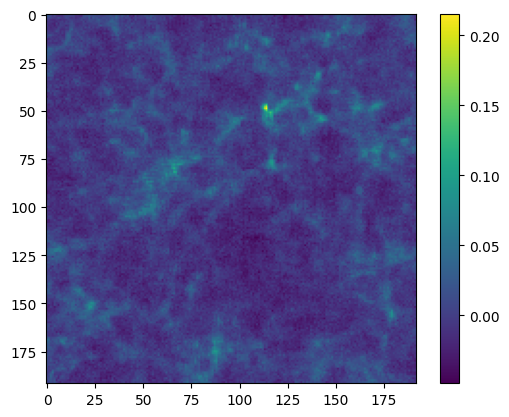

In [36]:
plt.imshow(prior_sims[0, 2, ...])
plt.colorbar()

In [37]:
# now compute Cls 

# ----- DO MOPED WITH ALL SIMS (NOISEFREE) -----
prior_cls = []
batch = 10
for i in tq(range(prior_sims.shape[0] // batch)):
    f_ = jax.vmap(cls_allbins_nonoise)(prior_sims[i*batch:(i+1)*batch]).reshape(-1, len(indices)*(num_bins))
    prior_cls.append(f_)

prior_cls = jnp.concatenate(prior_cls)

100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


In [38]:
prior_cls.shape

(5000, 60)

In [39]:
# compress with moped to get Cls summaries
moped_summaries = mymoped.compress(prior_cls)

In [40]:
batch = 100

outputs = jnp.concatenate([IMNN.get_estimate(prior_sims[i*batch:(i+1)*batch]) for i in tq(range(prior_sims.shape[0] // batch))])

100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


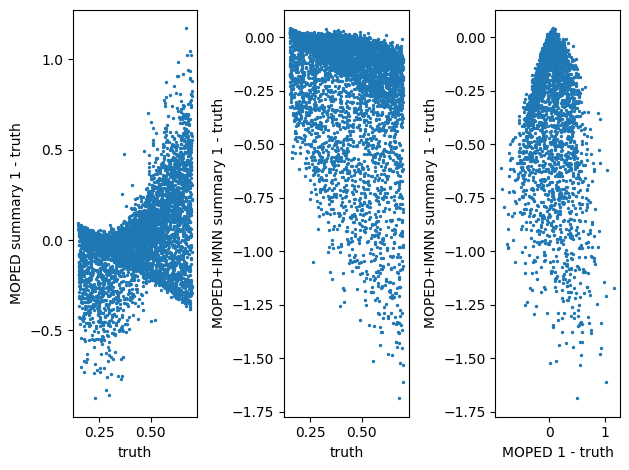

In [41]:
plt.subplot(131)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, 0] - prior_theta[:, 0]), outputs[:, 0] - prior_theta[:, 0], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

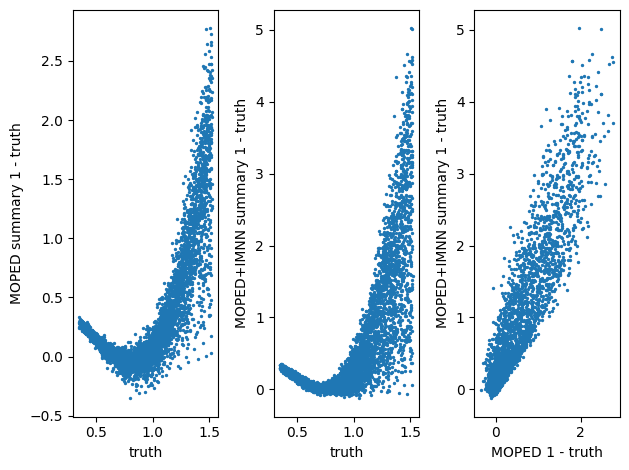

In [42]:
plt.subplot(131)
param = 1

plt.scatter(prior_theta[:, param], moped_summaries[:, param] - prior_theta[:, param], s=2)#, c=prior_theta[:, 1])
plt.xlabel(r"truth")
plt.ylabel(r"MOPED summary 1 - truth")

plt.subplot(132)
plt.scatter(prior_theta[:, param], outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"truth")

plt.subplot(133)
plt.scatter((moped_summaries[:, param] - prior_theta[:, param]), outputs[:, param] - prior_theta[:, param], s=2)
plt.ylabel(r"MOPED+IMNN summary 1 - truth")
plt.xlabel(r"MOPED 1 - truth")

            
plt.tight_layout()

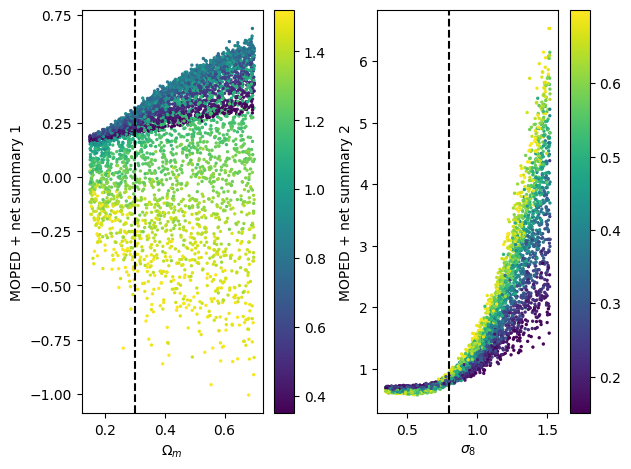

In [45]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

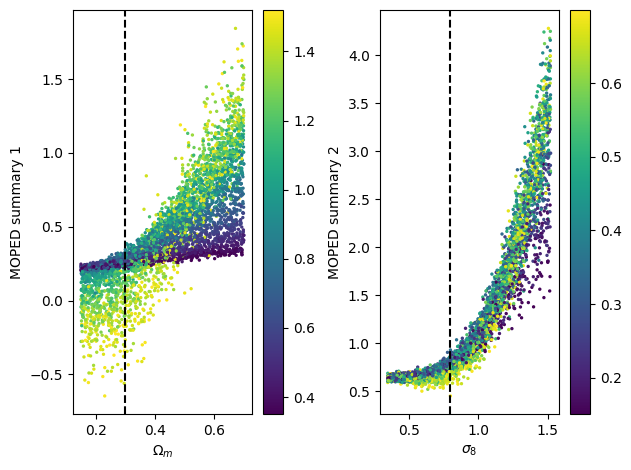

In [46]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()

plt.tight_layout()

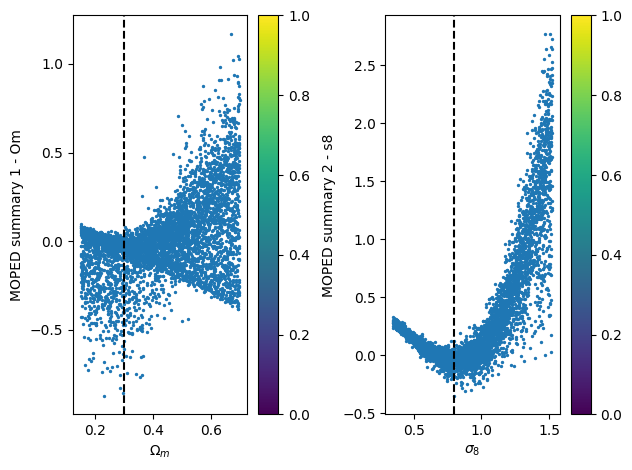

In [47]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], moped_summaries[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED summary 1 - Om")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], moped_summaries[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"MOPED summary 2 - s8")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

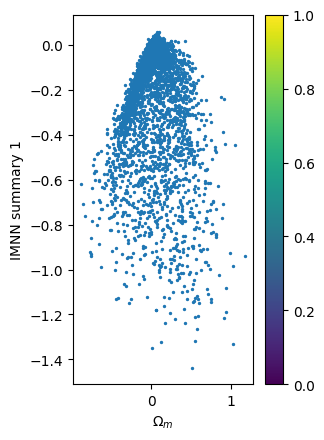

In [52]:
plt.subplot(121)
plt.scatter(moped_summaries[:, 0] - prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
#plt.axvline(0.3, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

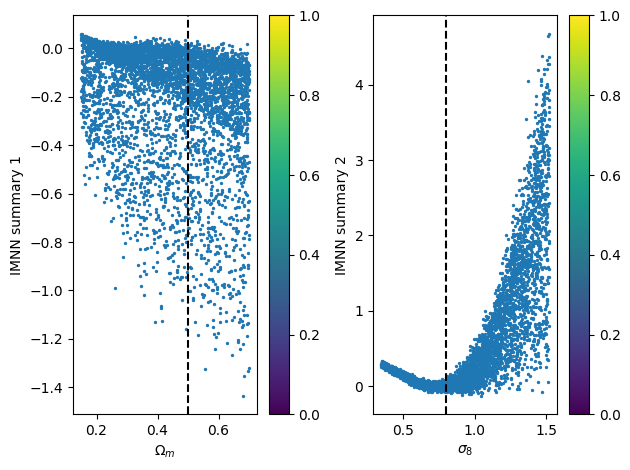

In [53]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], s=2)#, c=neural_summaries[:, 1])
plt.axvline(0.5, c="k", ls="--")

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"IMNN summary 1")
plt.colorbar()

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], s=2 )#, c=neural_summaries[:, 0])
plt.axvline(0.8, c="k", ls="--")
plt.ylabel(r"IMNN summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar()


plt.tight_layout()

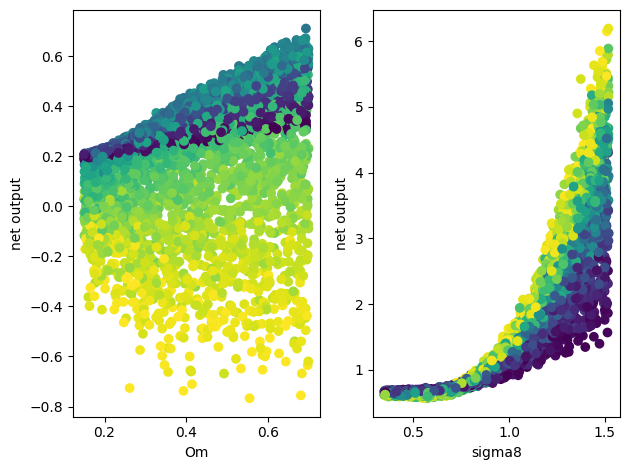

In [54]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("Om")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("sigma8")
plt.tight_layout()

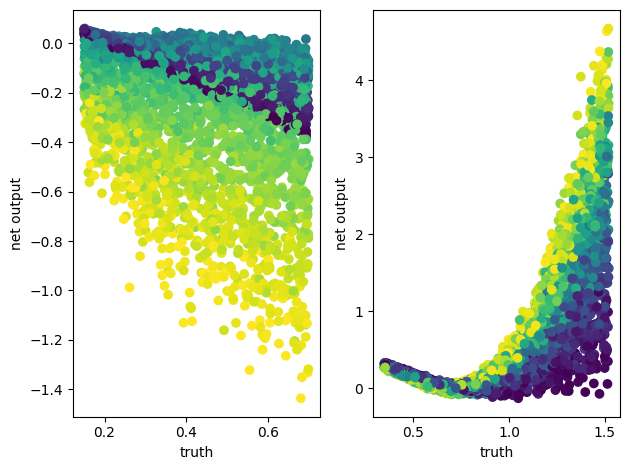

In [55]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("truth")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("truth")
plt.tight_layout()

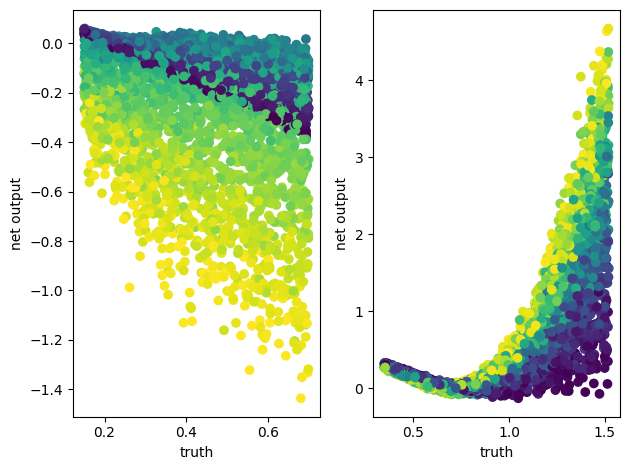

In [56]:
plt.subplot(121)
plt.scatter(prior_theta[:, 0], outputs[:, 0] - prior_theta[:, 0], c=prior_theta[:, 1])
plt.ylabel("net output")
plt.xlabel("truth")

plt.subplot(122)
plt.scatter(prior_theta[:, 1], outputs[:, 1] - prior_theta[:, 1], c=prior_theta[:, 0])
plt.ylabel("net output")
plt.xlabel("truth")
plt.tight_layout()

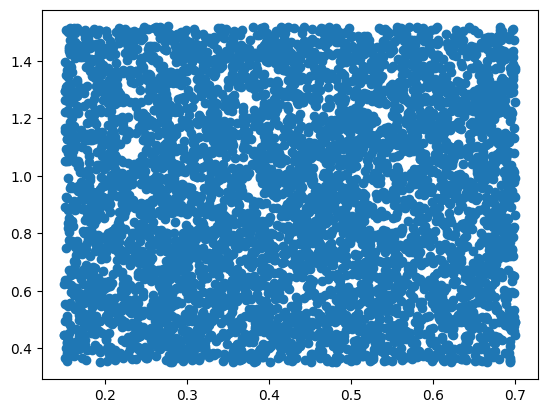

In [57]:
plt.scatter(prior_theta[:, 0], prior_theta[:, 1])

In [59]:
outdir

'/data101/makinen/lemur_sims/pm_sims/N192/'

In [48]:
target = jnp.load("/data101/makinen/lemur_sims/pm_sims/target_L_%d_N_%d_Nz_512.npz"%(L, N))["kappa"]
target_theta = jnp.load("/data101/makinen/lemur_sims/pm_sims/target_L_%d_N_%d_Nz_512.npz"%(L, N))["theta"]

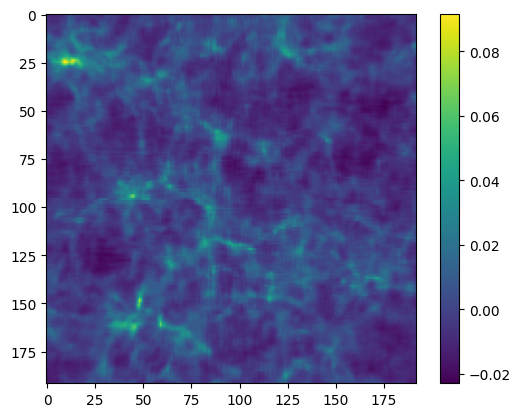

In [49]:
plt.imshow(target[2, ...])
plt.colorbar()

In [50]:
noise_target_key = jax.random.PRNGKey(604)
noisy_target = noise_simulator(noise_target_key, target, rot=True)
network_target = IMNN.get_estimate(noisy_target[jnp.newaxis, ...])

moped_target = mymoped.compress(cls_allbins_nonoise(noisy_target).reshape(-1, len(indices)*(num_bins)))

In [51]:
network_target, moped_target

(Array([[0.2905386 , 0.82839054]], dtype=float32),
 Array([[0.28361923, 0.83605146]], dtype=float32))

In [52]:
prior_sims.shape

(5000, 4, 192, 192)

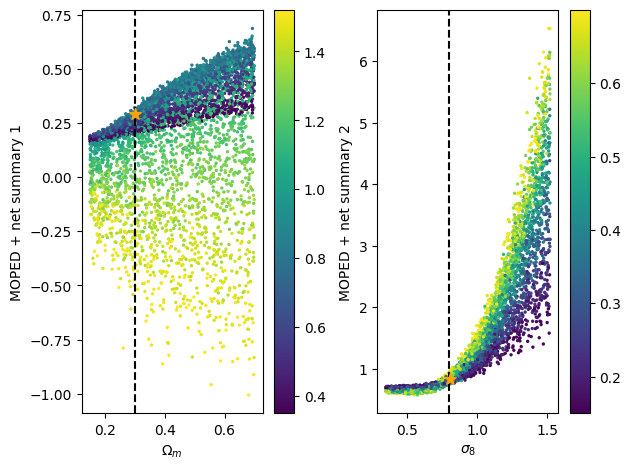

In [53]:
plt.subplot(121)
im = plt.scatter(prior_theta[:, 0], outputs[:, 0], s=2, c=prior_theta[:, 1])
plt.axvline(θ_fid[0], c="k", ls="--")
plt.scatter(target_theta[0], network_target[:, 0], c="orange", marker="*", s=74, zorder=23)

plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"MOPED + net summary 1")
plt.colorbar(im)

plt.subplot(122)
im = plt.scatter(prior_theta[:, 1], outputs[:, 1], s=2, c=prior_theta[:, 0])
plt.axvline(θ_fid[1], c="k", ls="--")
plt.scatter(target_theta[1], network_target[:, 1], c="orange", marker="*", s=74, zorder=23)
plt.ylabel(r"MOPED + net summary 2")
plt.xlabel(r"$\sigma_8$")
plt.colorbar(im)

plt.tight_layout()

In [55]:
# SAVE EVERYTHING FOR DENSITY ESTIMATION !!

np.savez("PM_S8_sbi_N192_target_2",
         moped_summaries=moped_summaries,
         #neural_summaries=neural_summaries,
         prior_theta=prior_theta,
         network_outputs=outputs,
         #model_out_number=model_out_number,
         target=target,
         noisy_target=noisy_target,
         target_theta=target_theta,
         network_target=network_target,
         moped_target=moped_target
        )

In [123]:
outputs.shape

(5000, 2)

In [124]:
prior_theta.shape, outputs.shape, moped_summaries.shape

((5000, 2), (5000, 2), (5000, 2))

In [393]:
IMNN.F

Array([[8880.529 , 1853.0272],
       [1853.0272, 1156.5256]], dtype=float32)

In [396]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(IMNN.w))

In [397]:
param_count

41031

In [399]:
128*128*4

65536